# Gensim Word2Vec

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

In [2]:
import os
cwd = os.getcwd()
cwd

'/Users/Salla/Dropbox (Aalto)/korp files/nlp-project/notebooks'

In [3]:
df = pd.read_csv("../output/speeches-1.csv", delimiter="|", lineterminator="\n")
df.shape

(50000, 4)

In [4]:
df.head()

,Unnamed: 0,speaker,date,speech
0,0,Maria Lohela,2015-11-06,Ensimmäiseen käsittelyyn esitellään päiväjärje...
1,1,Timo Heinonen (kok),2015-11-06,Arvoisa rouva puhemies! Tässä hallituksen esit...
2,2,Mikko Kärnä (kesk),2015-11-06,Arvoisa rouva puhemies! Edustaja Heinonen käyt...
3,3,Markus Mustajärvi (vas),2015-11-06,Arvoisa puhemies! Edustaja Heinosella ja edust...
4,4,Anne Kalmari (kesk),2015-11-06,"Arvoisa rouva puhemies! Edustajat Heinonen, Kä..."


In [5]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

Unnamed: 0    0
speaker       0
date          0
speech        0
dtype: int64

## Cleaning:

In [6]:
# https://spacy.io/usage/models
nlp = spacy.load('xx_ent_wiki_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)
    
brief_cleaning = (re.sub("^([A-Z]|Å|Ä|Ö)[a-zåäö]+$", ' ', str(row)).lower() for row in df['speech'])

t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

Time to clean up everything: 2.28 mins


(46336, 1)

## Bigrams:

In [7]:
from gensim.models.phrases import Phrases, Phraser

As `Phrases()` takes a list of list of words as input:

In [8]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:

In [9]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [18]:
bigram = Phraser(phrases)

INFO - 21:55:32: source_vocab length 3463739
INFO - 21:56:09: Phraser built with 5369 phrasegrams


Transform the corpus based on the bigrams detected:

In [20]:
sentences = bigram[sent]

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [21]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

355922

In [22]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

[',', '.', 'on', 'ja', 'että', 'se', 'tämä', 'myös', 'nyt', 'niin']

# Training the model
## Gensim Word2Vec Implementation:

In [23]:
import multiprocessing

from gensim.models import Word2Vec

## Why I seperate the training of the model in 3 steps:
I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [24]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [25]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [26]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 21:57:12: collecting all words and their counts
INFO - 21:57:12: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:57:16: PROGRESS: at sentence #10000, processed 1648110 words, keeping 120057 word types
INFO - 21:57:22: PROGRESS: at sentence #20000, processed 3523715 words, keeping 199176 word types
INFO - 21:57:28: PROGRESS: at sentence #30000, processed 5709299 words, keeping 274063 word types
INFO - 21:57:33: PROGRESS: at sentence #40000, processed 7578122 words, keeping 323301 word types
INFO - 21:57:37: collected 355922 word types from a corpus of 8903225 raw words and 46336 sentences
INFO - 21:57:37: Loading a fresh vocabulary
INFO - 21:57:37: effective_min_count=20 retains 32052 unique words (9% of original 355922, drops 323870)
INFO - 21:57:37: effective_min_count=20 leaves 8036591 word corpus (90% of original 8903225, drops 866634)
INFO - 21:57:37: deleting the raw counts dictionary of 355922 items
INFO - 21:57:37: sample=6e-05 downsamples 559 

Time to build vocab: 0.43 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [27]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 22:00:17: training model with 11 workers on 32052 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 22:00:18: EPOCH 1 - PROGRESS: at 4.05% examples, 132517 words/s, in_qsize 0, out_qsize 0
INFO - 22:00:19: EPOCH 1 - PROGRESS: at 7.80% examples, 135845 words/s, in_qsize 0, out_qsize 0
INFO - 22:00:20: EPOCH 1 - PROGRESS: at 11.32% examples, 135189 words/s, in_qsize 0, out_qsize 0
INFO - 22:00:21: EPOCH 1 - PROGRESS: at 14.49% examples, 133514 words/s, in_qsize 0, out_qsize 0
INFO - 22:00:22: EPOCH 1 - PROGRESS: at 18.19% examples, 135057 words/s, in_qsize 0, out_qsize 0
INFO - 22:00:23: EPOCH 1 - PROGRESS: at 21.91% examples, 135692 words/s, in_qsize 0, out_qsize 0
INFO - 22:00:24: EPOCH 1 - PROGRESS: at 24.86% examples, 134488 words/s, in_qsize 0, out_qsize 0
INFO - 22:00:25: EPOCH 1 - PROGRESS: at 28.13% examples, 134325 words/s, in_qsize 0, out_qsize 0
INFO - 22:00:26: EPOCH 1 - PROGRESS: at 31.26% examples, 134261 words/s, in_qsize 0, out_q

INFO - 22:01:25: EPOCH 3 - PROGRESS: at 11.05% examples, 131955 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:26: EPOCH 3 - PROGRESS: at 14.49% examples, 132014 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:27: EPOCH 3 - PROGRESS: at 17.92% examples, 131871 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:28: EPOCH 3 - PROGRESS: at 21.65% examples, 132682 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:29: EPOCH 3 - PROGRESS: at 24.86% examples, 132847 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:30: EPOCH 3 - PROGRESS: at 28.13% examples, 132743 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:31: EPOCH 3 - PROGRESS: at 31.17% examples, 132248 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:32: EPOCH 3 - PROGRESS: at 34.38% examples, 132413 words/s, in_qsize 1, out_qsize 0
INFO - 22:01:33: EPOCH 3 - PROGRESS: at 37.81% examples, 133183 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:34: EPOCH 3 - PROGRESS: at 41.11% examples, 133533 words/s, in_qsize 0, out_qsize 0
INFO - 22:01:35: EPOCH 3 - PRO

INFO - 22:02:32: EPOCH 5 - PROGRESS: at 14.87% examples, 135516 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:33: EPOCH 5 - PROGRESS: at 18.41% examples, 135451 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:34: EPOCH 5 - PROGRESS: at 22.14% examples, 136229 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:35: EPOCH 5 - PROGRESS: at 25.28% examples, 135839 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:37: EPOCH 5 - PROGRESS: at 28.72% examples, 135595 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:38: EPOCH 5 - PROGRESS: at 31.82% examples, 135034 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:39: EPOCH 5 - PROGRESS: at 35.01% examples, 134529 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:40: EPOCH 5 - PROGRESS: at 38.27% examples, 134436 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:41: EPOCH 5 - PROGRESS: at 41.54% examples, 134297 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:42: EPOCH 5 - PROGRESS: at 44.56% examples, 134764 words/s, in_qsize 0, out_qsize 0
INFO - 22:02:43: EPOCH 5 - PRO

INFO - 22:03:39: EPOCH 7 - PROGRESS: at 21.65% examples, 133136 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:40: EPOCH 7 - PROGRESS: at 24.86% examples, 133815 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:41: EPOCH 7 - PROGRESS: at 28.13% examples, 133643 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:42: EPOCH 7 - PROGRESS: at 31.17% examples, 133302 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:43: EPOCH 7 - PROGRESS: at 34.30% examples, 132838 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:44: EPOCH 7 - PROGRESS: at 37.14% examples, 131655 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:45: EPOCH 7 - PROGRESS: at 40.13% examples, 131334 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:46: EPOCH 7 - PROGRESS: at 43.44% examples, 131273 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:47: EPOCH 7 - PROGRESS: at 46.14% examples, 131358 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:48: EPOCH 7 - PROGRESS: at 49.05% examples, 131515 words/s, in_qsize 0, out_qsize 0
INFO - 22:03:49: EPOCH 7 - PRO

INFO - 22:04:46: EPOCH 9 - PROGRESS: at 28.87% examples, 137236 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:47: EPOCH 9 - PROGRESS: at 32.03% examples, 137117 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:48: EPOCH 9 - PROGRESS: at 35.35% examples, 137049 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:49: EPOCH 9 - PROGRESS: at 38.56% examples, 136934 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:50: EPOCH 9 - PROGRESS: at 41.78% examples, 136510 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:51: EPOCH 9 - PROGRESS: at 44.91% examples, 136560 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:52: EPOCH 9 - PROGRESS: at 47.71% examples, 136896 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:53: EPOCH 9 - PROGRESS: at 50.74% examples, 136586 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:54: EPOCH 9 - PROGRESS: at 53.69% examples, 136660 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:55: EPOCH 9 - PROGRESS: at 56.50% examples, 136461 words/s, in_qsize 0, out_qsize 0
INFO - 22:04:56: EPOCH 9 - PRO

INFO - 22:05:53: EPOCH 11 - PROGRESS: at 38.70% examples, 137314 words/s, in_qsize 1, out_qsize 0
INFO - 22:05:54: EPOCH 11 - PROGRESS: at 42.00% examples, 137255 words/s, in_qsize 0, out_qsize 0
INFO - 22:05:55: EPOCH 11 - PROGRESS: at 44.96% examples, 137182 words/s, in_qsize 1, out_qsize 0
INFO - 22:05:56: EPOCH 11 - PROGRESS: at 47.83% examples, 137320 words/s, in_qsize 0, out_qsize 0
INFO - 22:05:57: EPOCH 11 - PROGRESS: at 50.84% examples, 137156 words/s, in_qsize 0, out_qsize 0
INFO - 22:05:58: EPOCH 11 - PROGRESS: at 53.69% examples, 137060 words/s, in_qsize 0, out_qsize 0
INFO - 22:05:59: EPOCH 11 - PROGRESS: at 56.50% examples, 136709 words/s, in_qsize 0, out_qsize 0
INFO - 22:06:00: EPOCH 11 - PROGRESS: at 59.34% examples, 136563 words/s, in_qsize 0, out_qsize 0
INFO - 22:06:01: EPOCH 11 - PROGRESS: at 61.80% examples, 136439 words/s, in_qsize 0, out_qsize 0
INFO - 22:06:02: EPOCH 11 - PROGRESS: at 64.81% examples, 136438 words/s, in_qsize 0, out_qsize 0
INFO - 22:06:03: EPO

INFO - 22:07:00: EPOCH 13 - PROGRESS: at 36.05% examples, 127503 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:01: EPOCH 13 - PROGRESS: at 38.98% examples, 127602 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:02: EPOCH 13 - PROGRESS: at 42.23% examples, 127724 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:03: EPOCH 13 - PROGRESS: at 44.96% examples, 127496 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:04: EPOCH 13 - PROGRESS: at 47.62% examples, 127479 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:05: EPOCH 13 - PROGRESS: at 50.58% examples, 127939 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:06: EPOCH 13 - PROGRESS: at 53.13% examples, 127894 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:07: EPOCH 13 - PROGRESS: at 55.91% examples, 127831 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:08: EPOCH 13 - PROGRESS: at 58.52% examples, 127560 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:09: EPOCH 13 - PROGRESS: at 60.91% examples, 127352 words/s, in_qsize 0, out_qsize 0
INFO - 22:07:10: EPO

INFO - 22:08:06: EPOCH 15 - PROGRESS: at 26.04% examples, 124207 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:07: EPOCH 15 - PROGRESS: at 29.36% examples, 124118 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:08: EPOCH 15 - PROGRESS: at 32.30% examples, 124151 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:09: EPOCH 15 - PROGRESS: at 35.35% examples, 124486 words/s, in_qsize 1, out_qsize 0
INFO - 22:08:10: EPOCH 15 - PROGRESS: at 38.43% examples, 124824 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:11: EPOCH 15 - PROGRESS: at 41.42% examples, 124610 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:12: EPOCH 15 - PROGRESS: at 44.16% examples, 124522 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:13: EPOCH 15 - PROGRESS: at 46.78% examples, 124584 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:14: EPOCH 15 - PROGRESS: at 49.49% examples, 124703 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:15: EPOCH 15 - PROGRESS: at 52.18% examples, 124628 words/s, in_qsize 0, out_qsize 0
INFO - 22:08:16: EPO

INFO - 22:09:13: EPOCH 17 - PROGRESS: at 20.61% examples, 125674 words/s, in_qsize 0, out_qsize 0
INFO - 22:09:14: EPOCH 17 - PROGRESS: at 23.83% examples, 126242 words/s, in_qsize 0, out_qsize 0
INFO - 22:09:15: EPOCH 17 - PROGRESS: at 26.61% examples, 126112 words/s, in_qsize 0, out_qsize 0
INFO - 22:09:16: EPOCH 17 - PROGRESS: at 29.85% examples, 126152 words/s, in_qsize 0, out_qsize 0
INFO - 22:09:17: EPOCH 17 - PROGRESS: at 32.96% examples, 125879 words/s, in_qsize 1, out_qsize 0
INFO - 22:09:18: EPOCH 17 - PROGRESS: at 36.05% examples, 126175 words/s, in_qsize 0, out_qsize 0
INFO - 22:09:19: EPOCH 17 - PROGRESS: at 38.89% examples, 125871 words/s, in_qsize 1, out_qsize 0
INFO - 22:09:20: EPOCH 17 - PROGRESS: at 42.00% examples, 126061 words/s, in_qsize 0, out_qsize 0
INFO - 22:09:21: EPOCH 17 - PROGRESS: at 44.79% examples, 125968 words/s, in_qsize 0, out_qsize 0
INFO - 22:09:22: EPOCH 17 - PROGRESS: at 47.49% examples, 125880 words/s, in_qsize 1, out_qsize 0
INFO - 22:09:23: EPO

INFO - 22:10:21: EPOCH 19 - PROGRESS: at 21.24% examples, 130901 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:22: EPOCH 19 - PROGRESS: at 24.20% examples, 131013 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:23: EPOCH 19 - PROGRESS: at 27.60% examples, 131803 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:24: EPOCH 19 - PROGRESS: at 30.77% examples, 131572 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:25: EPOCH 19 - PROGRESS: at 33.96% examples, 131685 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:26: EPOCH 19 - PROGRESS: at 37.14% examples, 132206 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:27: EPOCH 19 - PROGRESS: at 40.42% examples, 132328 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:28: EPOCH 19 - PROGRESS: at 43.67% examples, 132345 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:29: EPOCH 19 - PROGRESS: at 46.34% examples, 132426 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:30: EPOCH 19 - PROGRESS: at 49.23% examples, 132420 words/s, in_qsize 0, out_qsize 0
INFO - 22:10:31: EPO

INFO - 22:11:28: EPOCH 21 - PROGRESS: at 28.72% examples, 135771 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:29: EPOCH 21 - PROGRESS: at 31.94% examples, 135885 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:30: EPOCH 21 - PROGRESS: at 35.24% examples, 135767 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:31: EPOCH 21 - PROGRESS: at 38.56% examples, 136211 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:32: EPOCH 21 - PROGRESS: at 42.00% examples, 136401 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:33: EPOCH 21 - PROGRESS: at 44.96% examples, 136279 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:34: EPOCH 21 - PROGRESS: at 47.83% examples, 136615 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:35: EPOCH 21 - PROGRESS: at 50.84% examples, 136438 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:36: EPOCH 21 - PROGRESS: at 53.69% examples, 136428 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:37: EPOCH 21 - PROGRESS: at 56.50% examples, 136304 words/s, in_qsize 0, out_qsize 0
INFO - 22:11:38: EPO

INFO - 22:12:35: EPOCH 23 - PROGRESS: at 38.98% examples, 138526 words/s, in_qsize 1, out_qsize 0
INFO - 22:12:36: EPOCH 23 - PROGRESS: at 42.41% examples, 138240 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:37: EPOCH 23 - PROGRESS: at 45.19% examples, 138179 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:38: EPOCH 23 - PROGRESS: at 48.16% examples, 138409 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:39: EPOCH 23 - PROGRESS: at 51.22% examples, 138338 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:40: EPOCH 23 - PROGRESS: at 53.96% examples, 138128 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:41: EPOCH 23 - PROGRESS: at 56.97% examples, 138034 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:42: EPOCH 23 - PROGRESS: at 59.87% examples, 137971 words/s, in_qsize 1, out_qsize 0
INFO - 22:12:43: EPOCH 23 - PROGRESS: at 62.28% examples, 137992 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:44: EPOCH 23 - PROGRESS: at 65.25% examples, 138006 words/s, in_qsize 0, out_qsize 0
INFO - 22:12:45: EPO

INFO - 22:13:41: EPOCH 25 - PROGRESS: at 47.92% examples, 137900 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:42: EPOCH 25 - PROGRESS: at 50.92% examples, 137771 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:43: EPOCH 25 - PROGRESS: at 53.85% examples, 137742 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:44: EPOCH 25 - PROGRESS: at 56.73% examples, 137580 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:45: EPOCH 25 - PROGRESS: at 59.58% examples, 137514 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:46: EPOCH 25 - PROGRESS: at 61.97% examples, 137442 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:47: EPOCH 25 - PROGRESS: at 64.90% examples, 137317 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:48: EPOCH 25 - PROGRESS: at 68.11% examples, 137122 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:49: EPOCH 25 - PROGRESS: at 71.67% examples, 136935 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:50: EPOCH 25 - PROGRESS: at 75.03% examples, 136851 words/s, in_qsize 0, out_qsize 0
INFO - 22:13:52: EPO

INFO - 22:14:48: EPOCH 27 - PROGRESS: at 56.46% examples, 136116 words/s, in_qsize 1, out_qsize 0
INFO - 22:14:49: EPOCH 27 - PROGRESS: at 59.26% examples, 136123 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:50: EPOCH 27 - PROGRESS: at 61.74% examples, 136249 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:51: EPOCH 27 - PROGRESS: at 64.63% examples, 136176 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:52: EPOCH 27 - PROGRESS: at 67.68% examples, 136111 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:53: EPOCH 27 - PROGRESS: at 71.50% examples, 136116 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:54: EPOCH 27 - PROGRESS: at 74.93% examples, 136136 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:55: EPOCH 27 - PROGRESS: at 78.34% examples, 136184 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:56: EPOCH 27 - PROGRESS: at 81.55% examples, 136058 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:57: EPOCH 27 - PROGRESS: at 84.41% examples, 135916 words/s, in_qsize 0, out_qsize 0
INFO - 22:14:58: EPO

INFO - 22:15:55: EPOCH 29 - PROGRESS: at 64.24% examples, 135077 words/s, in_qsize 1, out_qsize 0
INFO - 22:15:56: EPOCH 29 - PROGRESS: at 67.35% examples, 135090 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:57: EPOCH 29 - PROGRESS: at 71.04% examples, 135196 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:58: EPOCH 29 - PROGRESS: at 74.54% examples, 135167 words/s, in_qsize 0, out_qsize 0
INFO - 22:15:59: EPOCH 29 - PROGRESS: at 77.91% examples, 135351 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:00: EPOCH 29 - PROGRESS: at 81.24% examples, 135479 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:01: EPOCH 29 - PROGRESS: at 84.22% examples, 135604 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:02: EPOCH 29 - PROGRESS: at 87.30% examples, 135660 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:03: EPOCH 29 - PROGRESS: at 90.18% examples, 135582 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:04: EPOCH 29 - PROGRESS: at 92.66% examples, 135622 words/s, in_qsize 0, out_qsize 0
INFO - 22:16:05: EPO

Time to train the model: 16.35 mins


In [28]:
w2v_model.save("w2v.model")

INFO - 22:17:02: saving Word2Vec object under w2v.model, separately None
INFO - 22:17:02: not storing attribute vectors_norm
INFO - 22:17:02: not storing attribute cum_table
INFO - 22:17:03: saved w2v.model


In [29]:
# Make model more memory-efficient
w2v_model.init_sims(replace=True)

INFO - 22:17:08: precomputing L2-norms of word weight vectors


# Exploring the model
## Most similar to:


In [30]:
w2v_model.wv.most_similar(positive=["keskusta"])

[('sdp', 0.6099261045455933),
 ('kokoomus', 0.53276127576828),
 ('oppositio', 0.49862906336784363),
 ('keskustakin', 0.4885900318622589),
 ('hallitus', 0.4811936914920807),
 ('vasemmistoliitto', 0.4717361032962799),
 ('vasemmistoliiton_eduskuntaryhmä', 0.4441106617450714),
 ('puheenjohtaja_sipilä', 0.4385491907596588),
 ('keskustan_puheenjohtaja', 0.4366309940814972),
 ('keskustapuolue', 0.4364476501941681)]

_A small precision here:_<br>
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do **not** necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [32]:
w2v_model.wv.most_similar(positive=["juha"])

[('peter', 0.6300086379051208),
 ('jyrki', 0.6143772006034851),
 ('arto', 0.611545741558075),
 ('sirpa', 0.603858232498169),
 ('annika', 0.603774905204773),
 ('raija', 0.6013807058334351),
 ('paula', 0.5984580516815186),
 ('antero', 0.5895487666130066),
 ('lasse', 0.5856174230575562),
 ('liisa', 0.585490882396698)]

In [33]:
w2v_model.wv.most_similar(positive=["sipilä"])

[('juha_sipilä', 0.5515426993370056),
 ('stubb', 0.54470294713974),
 ('keskustan_puheenjohtaja', 0.5379858016967773),
 ('tiilikainen', 0.49200698733329773),
 ('kääriäinen', 0.48941704630851746),
 ('puheenjohtaja_rinne', 0.4841976463794708),
 ('ministeri_soini', 0.4775661826133728),
 ('soini', 0.4685269892215729),
 ('arhinmäki', 0.46546730399131775),
 ('turunen', 0.4608604311943054)]

In [42]:
w2v_model.wv.most_similar(positive=["orpo"])

[('petteri', 0.6123883724212646),
 ('räsänen', 0.5781139135360718),
 ('päivi', 0.5679245591163635),
 ('penttilä', 0.5669533610343933),
 ('richardson', 0.5642906427383423),
 ('wallin', 0.5616503357887268),
 ('lehtomäki', 0.554293155670166),
 ('kulmala', 0.553653359413147),
 ('paula', 0.5520431399345398),
 ('haatainen', 0.5515329241752625)]

## Similarities:

In [34]:
w2v_model.wv.similarity("keskusta", 'kokoomus')

0.53276134

In [43]:
w2v_model.wv.similarity('juha_sipilä', 'orpo')

0.36229452

## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

In [44]:
w2v_model.wv.doesnt_match(['keskusta', 'juha_sipilä', 'orpo'])

'orpo'

In [47]:
w2v_model.wv.doesnt_match(['kokoomus', 'juha_sipilä', 'orpo'])

'kokoomus'

## Analogy difference:

In [50]:
w2v_model.wv.most_similar(positive=["orpo"], negative=["keskusta","sipilä"], topn=3)

[('-_ohjelmien', 0.30250149965286255),
 ('asiakirjojen', 0.26347383856773376),
 ('fyysinen', 0.26335152983665466)]

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [55]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

## 10 Most similar words vs. 10 Most dissimilar


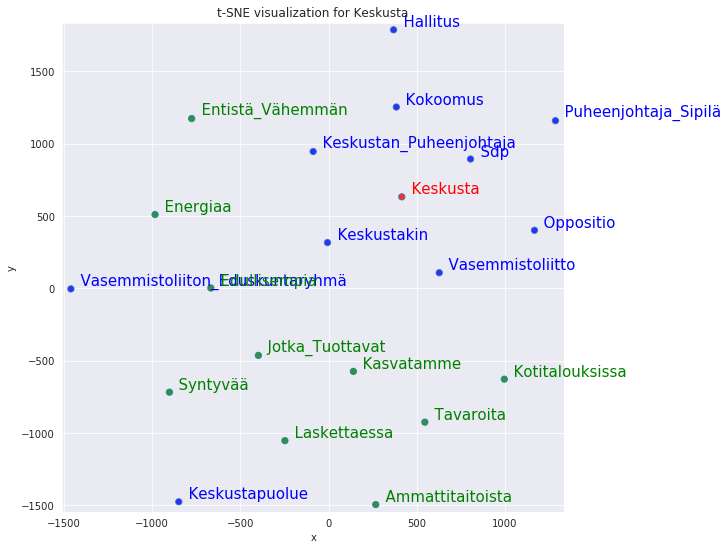

In [56]:
tsnescatterplot(w2v_model, 'keskusta', [i[0] for i in w2v_model.wv.most_similar(negative=["orpo"])])

## 10 Most similar words vs. 11th to 20th Most similar words:


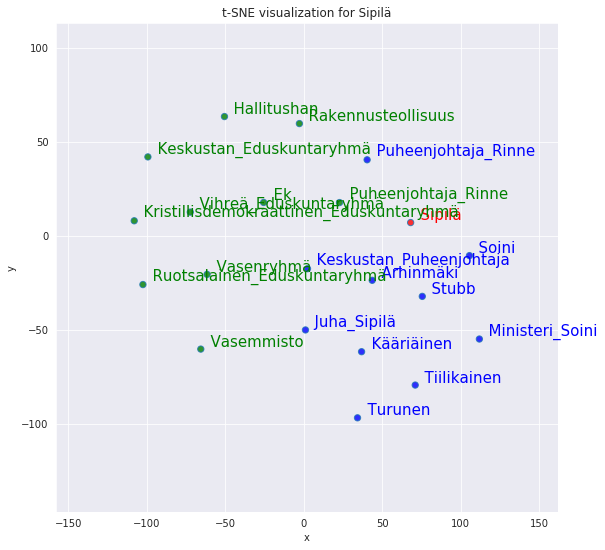

In [57]:
tsnescatterplot(w2v_model, "sipilä", [t[0] for t in w2v_model.wv.most_similar(positive=["keskusta"], topn=20)][10:])